In [1]:
# %reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import igraph as ig

from numpy import sqrt
from gurobipy import GRB
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
# matplotlib.use('TkAgg')

In [2]:
## 数据读取与参数设置
def dist(p1, p2):
    return sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def viaShop(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3)

def Charge_viaShop(p1, p2, p3, p4):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p4)

# 读取Excel文件
df1 = pd.read_excel('./q3data.xlsx')
df1['points'] = df1.apply(lambda row: [row['x'], row['y']], axis=1)
df1.drop(columns=['x', 'y'], inplace=True)

# 参数设置
M = 1 << 16
droneSpeed = 60
droneMaxPower = 10
droneNumber = 10
userNumber = df1.shape[0]

shop = [[0.5, 0], [0, 0.5]]
chargeStation = [0, 0]

# 构建耗时矩阵
matSize = 4 * userNumber + 2
distMat = np.full((matSize, matSize), float(M))
for i in range(4 * userNumber + 1):
    for j in range(1, 4 * userNumber + 2):
        if i >= 1:
            userPoint1 = df1.loc[(i - 1) % userNumber, 'points']
        if j >= 1:
            userPoint2 = df1.loc[(j - 1) % userNumber, 'points']
        if 1 <= j <= userNumber:
            if i == 0:
                distMat[i, j] = viaShop(chargeStation, shop[0], userPoint2)
            else:
                distMat[i, j] = viaShop(userPoint1, shop[0], userPoint2) 
        elif userNumber + 1 <= j <= 2 * userNumber:
            if i == 0:
                distMat[i, j] = viaShop(chargeStation, shop[1], userPoint2)
            else:
                distMat[i, j] = viaShop(userPoint1, shop[1], userPoint2) 
        elif 2 * userNumber + 1 <= j <= 3 * userNumber:
            if i == 0:
                continue
            else:
                distMat[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[0], userPoint2)
        elif 3 * userNumber + 1 <= j <= 4 * userNumber:
            if i == 0:
                continue
            else:
                distMat[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[1], userPoint2)
        elif j == 4 * userNumber + 1:
            if i == 0:
                continue
            else:
                distMat[i, j] = dist(userPoint1, chargeStation)               

In [3]:
## 第三问线性规划

# 确认分块点集
Sp = [0]
Ep = [matSize - 1]
I = [list(range(1, userNumber + 1)), 
     list(range(userNumber + 1, 2 * userNumber + 1)),
     list(range(2 * userNumber + 1, 3 * userNumber + 1)), 
     list(range(3 * userNumber + 1, 4 * userNumber + 1))]
fullI = I[0] + I[1] + I[2] + I[3]
U = Sp + fullI + Ep


prob3 = gp.Model('q3无人机调度')

x = prob3.addVars(droneNumber, matSize, matSize, vtype=GRB.BINARY, name='workingPath')
phi = prob3.addVars(droneNumber, matSize, lb=0, ub=10, vtype=GRB.CONTINUOUS, name='remainPower')
u = prob3.addVars(droneNumber, matSize, vtype=GRB.INTEGER, name='order')
d = prob3.addVars(droneNumber, vtype=GRB.CONTINUOUS, name='dis')
dMax = prob3.addVar(vtype=GRB.CONTINUOUS, name='disMax')

## 约束

# 对于每一个无人机
for k in range(droneNumber):
    # 不可能路径约束
    prob3.addConstr(gp.quicksum(x[k, i, j] for i in U for j in Sp) == 0)
    prob3.addConstr(gp.quicksum(x[k, i, j] for i in Sp for j in (I[2] + I[3] + Ep)) == 0)
    prob3.addConstr(gp.quicksum(x[k, i, j] for i in Ep for j in (fullI + Ep)) == 0)
    # 每一个分块矩阵的对角线都为0
    for c1 in range(4):
        for c2 in range(4):
            row_start = I[c1][0]
            col_start = I[c2][0]
            for i in range(userNumber):
                prob3.addConstr(x[k, row_start + i, col_start + i] == 0)

    # 起点终点约束
    prob3.addConstr(gp.quicksum(x[k, 0, j] for j in I[0] + I[1]) == 1)
    prob3.addConstr(gp.quicksum(x[k, i, matSize - 1] for i in fullI) == 1)
    
    # 连续路径约束
    for i in range(1, matSize - 1):
        prob3.addConstr(gp.quicksum(x[k, i, j] for j in U) == 
                        gp.quicksum(x[k, j, i] for j in U))
    
    # MTZ约束
    # 起点
    prob3.addConstr(u[k, 0] == 1)
    # 起点到第一个顾客
    prob3.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                     for i in Sp for j in (I[0] + I[1]))
    # 顾客到顾客
    prob3.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                     for i in fullI for j in fullI)
    # 顾客到终点
    prob3.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                     for i in fullI for j in Ep)
    
    # 起始电量
    prob3.addConstr(phi[k, 0] == 10)
    
    # 不充电
    for i in (Sp + fullI):
        for j in (I[0] + I[1]):
            prob3.addConstr(phi[k, j] <= phi[k, i] - distMat[i, j] + M * (1 - x[k, i, j]))
            prob3.addConstr(phi[k, j] >= phi[k, i] - distMat[i, j] - M * (1 - x[k, i, j]))
    for i in fullI:
        for j in Ep:
            prob3.addConstr(phi[k, j] <= phi[k, i] - distMat[i, j] + M * (1 - x[k, i, j]))
            prob3.addConstr(phi[k, j] >= phi[k, i] - distMat[i, j] - M * (1 - x[k, i, j]))
    
    # 充电
    for i in fullI:
        for j in I[2] + I[3]:
            prob3.addConstr(phi[k, j] <= 10 - distMat[0, j % userNumber] + M * (1 - x[k, i, j]))
            prob3.addConstr(phi[k, j] >= 10 - distMat[0, j % userNumber] - M * (1 - x[k, i, j]))
    
    # 每一个无人机的耗时
    prob3.addConstr(d[k] == gp.quicksum(x[k, i, j] * distMat[i, j] for i in U for j in U))

# 更改顾客服务约束
for i in range(1, userNumber + 1):
    pos1 = i
    pos2 = i + userNumber
    pos3 = i + 2 * userNumber
    pos4 = i + 3 * userNumber
    prob3.addConstr(gp.quicksum(x[k, pos1, j] + x[k, pos2, j] + x[k, pos3, j] + x[k, pos4, j]
                                for j in U for k in range(droneNumber)) == 1)

# 最大耗时约束
prob3.addConstrs(dMax >= d[k] for k in range(droneNumber))

## 目标函数
prob3.setObjective(dMax)
prob3.write('./q3model.lp')


In [4]:
prob3.Params.NoRelHeurTime = 100
prob3.Params.TimeLimit = 100
prob3.Params.MIPFocus = 3
prob3.optimize()

Set parameter NoRelHeurTime to value 100
Set parameter TimeLimit to value 120
Set parameter MIPFocus to value 3
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 199710 rows, 68891 columns and 788530 nonzeros
Model fingerprint: 0x30d1d8cd
Variable types: 831 continuous, 68060 integer (67240 binary)
Coefficient statistics:
  Matrix range     [7e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 59200 rows and 8360 columns (presolve time = 5s) ...
Presolve removed 59200 rows and 8360 columns (presolve time = 10s) ...
Presolve removed 59200 rows and 8360 columns
Presolve time: 10.43s
Presolved: 140510 rows, 60531 columns, 674340 nonzeros
Variable types: 791 continuous, 59740 integer (58940 binary)

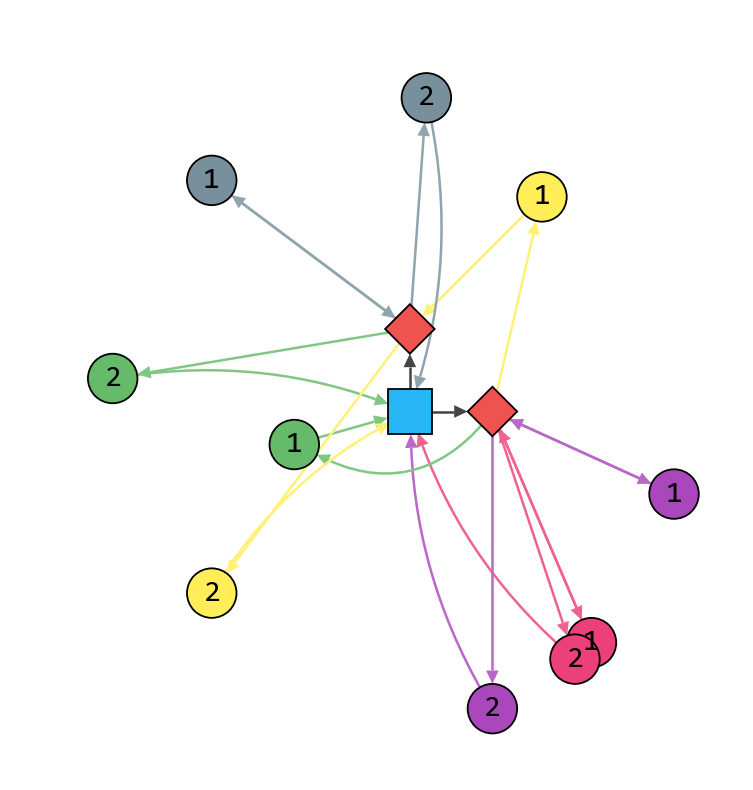

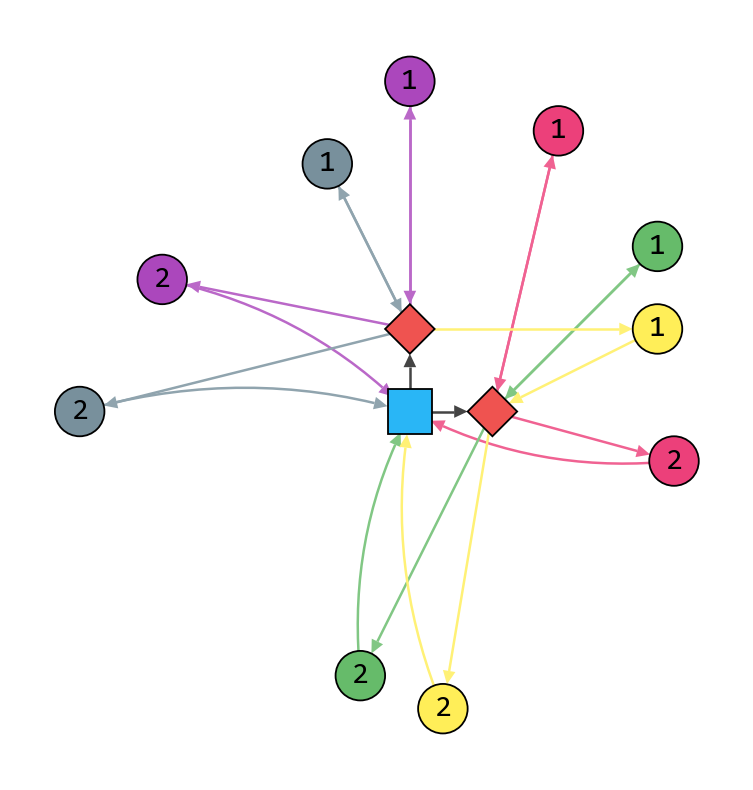

In [64]:
def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

def getShopNumber(num, user_number):
    if 1 <= num <= user_number:
        return 1
    elif user_number + 1 <= num <= 2 * user_number + 1:
        return 2
    elif 2 * user_number + 1 <= num <= 3 * user_number + 1:
        return 1
    elif 3 * user_number + 1 <= num <= 4 * user_number + 1:
        return 2

def draw_graph(df, charge_station, shops, paths):
    # 两架无人机的轨迹颜色
    edge_color = ['#F06292','#BA68C8','#81C784','#FFF176','#90A4AE']
    node_color = ['#EC407A','#AB47BC','#66BB6A','#FFEE58','#78909C']
    
    g = ig.Graph(directed=True)
    
    user_number = df.shape[0]
    shop_number = len(shops)
    total_nodes = 1 + shop_number + user_number
    # 添加点顺序：充电站--商店(2个)--顾客(20个)
    g.add_vertices(total_nodes)
    g.vs["x"] = ([charge_station[0]] + 
                 [shops[i][0] for i in range(len(shops))]+
                 [df.points[i][0] for i in range(len(df1.points))])
    g.vs["y"] = ([charge_station[1]] + 
                 [shops[i][1] for i in range(len(shops))]+
                 [df.points[i][1] for i in range(len(df1.points))])
    g.vs["shape"] = ["rectangle", "diamond", "diamond"] + ["circle" for _ in range(user_number)]
    g.vs["color"] = ["#29B6F6", "#EF5350", "#EF5350"] + ["#FFEE58" for _ in range(user_number)]
    g.vs["size"] = [0.27, 0.3, 0.3] + [0.3 for _ in range(user_number)]
    
    # 建立path点到图中点的映射字典
    point_dict = {}
    for i in range(1, 4 * user_number + 1):
        point_dict[i] = ((i - 1) % user_number) + 1 + shop_number
    
    # 无人机服务过的顾客
    visited = set()
    # 标记起点
    visited.add(shop_number)
    
    # 添加两个固定的黑色边
    start_point = 0
    shop_point1 = 1
    shop_point2 = 2
    g.add_edge(start_point, shop_point1, curved=0.0)
    g.add_edge(start_point, shop_point2, curved=0.0)
    # 遍历path添加边
    for k, path in enumerate(paths):
        for i in range(len(path) - 1):
            if i == 0:
                end_point = point_dict[path[i + 1]]
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[k]
                visited.add(end_point)
                continue
            elif i == len(path) - 2:
                start_point = point_dict[path[i]]
                pre_shop_point = getShopNumber(path[i],user_number)
                end_point = 0
                # 添加一条边
                g.add_edge(pre_shop_point, start_point, curved=0.0, color=edge_color[k])
                g.add_edge(start_point, end_point, curved=0.17, color=edge_color[k])
                continue
                
            # 中间的情况
            if 1 <= path[i + 1] <= 2 * user_number:
                # 不充电，走第一个商店shops[0]，对应编号：1
                pre_shop_point = getShopNumber(path[i], user_number)
                start_point = point_dict[path[i]]
                nxt_shop_point = getShopNumber(path[i + 1], user_number)
                end_point = point_dict[path[i + 1]]
                g.add_edge(pre_shop_point, start_point, curved=0, color=edge_color[k])
                g.add_edge(start_point, nxt_shop_point, curved=0, color=edge_color[k])
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[k]
                visited.add(end_point)
            elif 2 * user_number + 1 <= path[i + 1] <= 4 * user_number:
                # 充电，走第一个商店shops[0]，对应编号：1
                charge_point = 0
                pre_shop_point = getShopNumber(path[i], user_number)
                start_point = point_dict[path[i]]
                nxt_shop_point = getShopNumber(path[i + 1], user_number)
                end_point = point_dict[path[i + 1]]
                g.add_edge(pre_shop_point, start_point, curved=0.5, color=edge_color[k])
                g.add_edge(start_point, charge_point, curved=0, color=edge_color[k])
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[k]
                visited.add(end_point)

                
    # 隐藏未服务过的顾客
    for i in range(1 + shop_number, total_nodes):
        if i not in visited:
            g.vs[i]['color'] = 'white'         
            g.vs[i]['width'] = 0
    return g

xMat = np.zeros((droneNumber, matSize, matSize))
Paths = []
for k in range(droneNumber):
    for i in range(matSize):
        for j in range(matSize):
            xMat[k, i, j] = x[k, i, j].x
        
    Paths.append(find_cycle_points(xMat[k], 0))

# 绘制第1到第5号无人机的路线图

showInFig1 = [0, 2, 3, 4, 6]
showInFig2 = [x for x in list(range(droneNumber)) if x not in showInFig1]
g1 = draw_graph(df1, chargeStation, shop, [Paths[i] for i in showInFig1])

layout1 = g1.layout_auto()
fig1, ax1 = plt.subplots(figsize=(40, 10))
ig.plot(g1, target=ax1, layout=layout1, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)
plt.savefig('q3工作路径(无人机展示编号：1_3_4_5_7).svg', format="svg", bbox_inches='tight',pad_inches=-0.4)

# 绘制第6到第10号无人机的路线图
g2 = draw_graph(df1, chargeStation, shop, [Paths[i] for i in showInFig2])

layout2 = g2.layout_auto()
fig2, ax2 = plt.subplots(figsize=(40, 10))
ig.plot(g2, target=ax2, layout=layout2, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)
plt.savefig('q3工作路径(无人机展示编号：2_6_8_9_10).svg', format="svg", bbox_inches='tight',pad_inches=-0.4)

In [16]:
## 生成问题三收敛结果

# 生成问题一结果报告
import time
def mycallback(model, where):
    if where == GRB.Callback.MIP:
        # MIP solution callback
        currentTime = time.time()
        solName = int((currentTime - model._startTime) / model._interval) * model._interval
        
        # Statistics
        obj = model.cbGet(GRB.Callback.MIP_OBJBST)

        # Export statistics
        msg = str(currentTime-model._startTime) + " " + str(obj) + "\n"
        model._reportFile.write(msg)
        model._reportFile.flush()
        
model = gp.read('q3model.lp')
# 求解参数
model.Params.NoRelHeurTime = 120
model.Params.TimeLimit = 120

reportFile = open('q3report.txt', 'w')

model._startTime = time.time()
model._reportFile = reportFile
model._interval = 1  #每隔一段时间输出当前可行解，单位秒

model.optimize(mycallback)



Read LP format model from file q3model.lp
Reading time = 0.82 seconds
: 199710 rows, 68891 columns, 788530 nonzeros
Set parameter NoRelHeurTime to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 199710 rows, 68891 columns and 788530 nonzeros
Model fingerprint: 0x925d43db
Variable types: 831 continuous, 68060 integer (67240 binary)
Coefficient statistics:
  Matrix range     [7e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 59200 rows and 8360 columns
Presolve time: 2.93s
Presolved: 140510 rows, 60531 columns, 674340 nonzeros
Variable types: 791 continuous, 59740 integer (58940 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 3
Found phase-1 solution

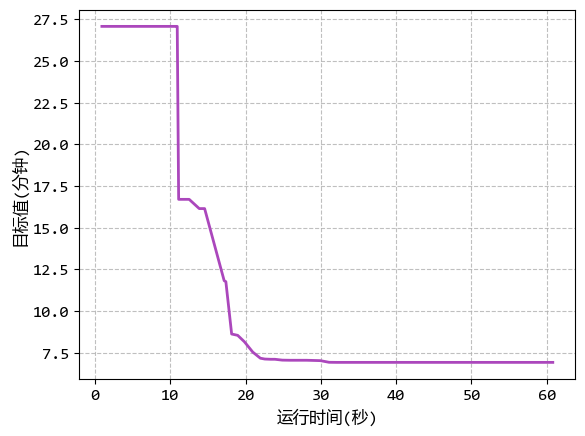

In [17]:
# 绘制收敛曲线
def read_report(filepath,save_name):
    # 存储数据的列表
    timestamps = []
    obj_values = []

    # 读取txt文件
    with open(filepath, 'r') as file:
        for line in file:
            # 分割每行的数据
            parts = line.split(' ')
            timestamp = float(parts[0].strip())
            obj_value = float(parts[1].strip())
            timestamps.append(timestamp)
            obj_values.append(obj_value)
    # 绘制图形
    plt.plot(timestamps, obj_values, color='#AB47BC', linestyle='-', linewidth=2)
    plt.xlabel('运行时间(秒)')
    plt.ylabel('目标值(分钟)')
    plt.grid(ls='--',alpha=0.8)
    plt.savefig(save_name, format='svg')

read_report('./q3report.txt','q3收敛曲线.svg')